In [1]:
import razor.flow as rf
from razor.api import datasources, engines, project_space_path
import logging
import time
import typing as typ
import numpy as np
import pandas as pd

logger = logging.getLogger()

In [2]:
@rf.block
class STDIn:
    filename: str
    out_ds: rf.Output[typ.Any] = rf.Output(transport=rf.KafkaTransport)

    def run(self):
        df = pd.read_parquet(project_space_path(self.filename))

        logger.info(df.shape)
        self.out_ds.put(df)
        
        
@rf.block
class AxisSum:
    in_ds: typ.Any
    out_ds: rf.Output[typ.Any] = rf.Output(transport=rf.KafkaTransport)

    def run(self):
        df = self.in_ds.copy()
        df['x_temp'] = df.sum(axis=1)
        self.out_ds.put(df)
        
        
@rf.block
class SumAxisSum:
    in_ds: typ.Any
    out_ds: rf.Output[typ.Any] = rf.Output(transport=rf.KafkaTransport)

    def run(self):        
        df = self.in_ds.copy()
        logger.info(df['x_temp'].sum())
        self.out_ds.put(df)
        
        
@rf.block
class DropAxisSum:
    in_ds: typ.Any
    out_ds: rf.Output[typ.Any] = rf.Output(transport=rf.KafkaTransport)

    def run(self):
        df = self.in_ds.copy()
        df.drop(['x_temp'], axis=1, inplace=True)
        self.out_ds.put(df)
        
        
@rf.block
class STDOut:
    in_ds: typ.Any
    out_filename: str

    def run(self):
        logger.info(self.in_ds.shape)
        self.in_ds.to_parquet(project_space_path(self.out_filename), index=False)
        

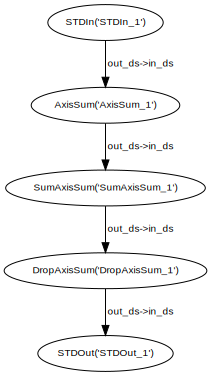

In [3]:
config = {'cores': 1, 'ram': 4096}

size = '10MB'
ip_filename = "/data/sdk_testbench/input_data/dummy_"+size+"_df.parquet"
op_filename = "/data/sdk_testbench/output_data/s_tc_21.parquet"


std_in = STDIn(filename=ip_filename)
std_in.executor = rf.ContainerExecutor(cores=config['cores'], memory=config['ram'])

axis_sum = AxisSum(in_ds=std_in.out_ds)
axis_sum.executor = rf.ContainerExecutor(cores=config['cores'], memory=config['ram'])

sum_axis_sum = SumAxisSum(in_ds=axis_sum.out_ds)
sum_axis_sum.executor = rf.ContainerExecutor(cores=config['cores'], memory=config['ram'])

drop_axis_sum = DropAxisSum(in_ds=sum_axis_sum.out_ds)
drop_axis_sum.executor = rf.ContainerExecutor(cores=config['cores'], memory=config['ram'])

stdout = STDOut(in_ds=drop_axis_sum.out_ds, out_filename=op_filename)

pipeline = rf.Pipeline(name='kafka_atomic_quad_pipeline', targets=[stdout])
pipeline.show()

In [4]:
def create_pipeline():
    return pipeline